In [11]:
import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision import datasets, transforms
from echotorch.nn import ESN, LiESN
import numpy as np
from scipy.special import softmax
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
from matplotlib import animation
from operator import itemgetter
from mpl_toolkits.mplot3d import Axes3D

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
def create_loaders(dataset_size=100, use_bw=False):
	reduced_train_size = int(60000 * dataset_size / 100)
	kwargs = {'num_workers': 1, 'pin_memory': True}

	train_dataset = datasets.MNIST('../data', train=True, download=True,
	                       transform=transforms.Compose([
	                           transforms.ToTensor(),
	                           transforms.Normalize((0.1307,), (0.3081,))
	                       ]))

	test_dataset = datasets.MNIST('../data', train=False, transform=transforms.Compose([
	                           transforms.ToTensor(),
	                           transforms.Normalize((0.1307,), (0.3081,))
	                       ]))

	reduced_indices = list(range(60000))
	np.random.shuffle(reduced_indices)
	reduced_indices = reduced_indices[:reduced_train_size]
	reduced_sampler = SubsetRandomSampler(reduced_indices)

	test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True, **kwargs)
	reduced_train_loader = DataLoader(train_dataset, batch_size=1, sampler=reduced_sampler, **kwargs)

	test_imgs = torch.empty((10000, 28*28))
	test_labels = torch.empty((10000, 1))

	for batch_num, (data, label) in enumerate(test_loader):
		img = torch.flatten(data).to(torch.float)

		if use_bw:
			threshold = (torch.max(img) - torch.min(img)) / 2
			img = (img > threshold).to(torch.float)

		test_imgs[batch_num] = img
		test_labels[batch_num] = torch.tensor(label).to(torch.float)

	reduced_train_imgs = torch.empty((reduced_train_size, 28*28))
	reduced_train_labels = torch.empty((reduced_train_size, 10))

	for batch_num, (data, label) in enumerate(reduced_train_loader):
		img = torch.flatten(data).to(torch.float)

		if use_bw:
			threshold = (torch.max(img) - torch.min(img)) / 2
			img = (img > threshold).to(torch.float)

		reduced_train_imgs[batch_num] = img
		reduced_train_labels[batch_num] = torch.zeros(10)
		reduced_train_labels[batch_num][label] = torch.tensor(1).to(torch.float)

	return reduced_train_imgs, reduced_train_labels, test_loader

In [ ]:
# np_labels = np.where(reduced_train_labels.numpy() == 1)
# label_hist = np.histogram(np_labels, bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
#
# np_img = reduced_train_imgs[0].numpy().reshape((28, 28))
# lbl = reduced_train_labels[0].numpy()

In [ ]:
def train_model(res_size, alpha, sparsity):
	torch.cuda.empty_cache()
	esn = LiESN(
		input_dim=28*28,
		hidden_dim=res_size,
		output_dim=10,
		w_sparsity=sparsity,
		leaky_rate=alpha
	).to(device)

	# for input, label in train_loader:
	input = reduced_train_imgs.view(1, -1, 28*28).to(torch.float).to(device)
	label = reduced_train_labels.view(1, -1, 10).to(torch.float).to(device)
	print(f'Training shape {input.shape}')
	esn(input, label)

	esn.finalize()

	return esn

In [ ]:
def test_model(model, res_size, alpha, sparsity):
	accuracy = 0
	results = np.zeros(10000)

	for num, (img, label) in enumerate(test_loader):
		label = label.item()
		result = model(img.view(1, -1, 28*28).to(torch.float).to(device))
		prediction = softmax(result.cpu().numpy()).flatten()
		prediction = np.argmax(prediction, 0)

		accuracy += prediction == label
		results[num] = prediction

	print(f'{res_size} nodes, {alpha}, {sparsity}: {accuracy / 100}')
	return accuracy / 100

In [ ]:
results = {}

SIZES = [500, 550, 600, 650, 700, 750, 800]
ALPHA = [0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
SPARSITY = [0.05, 0.1, 0.15, 0.2, 0.25]

# for res_size in tqdm(SIZES):
# 	for alpha in tqdm(ALPHA):
# 		for sparsity in SPARSITY:
# 			model = train_model(res_size, alpha, sparsity)
# 			accuracy = test_model(model, res_size, alpha, sparsity)
# 			stats[(res_size, alpha, sparsity)] = accuracy

# res_size = 650
# for exp_num in trange(10):
# 	for alpha in ALPHA:
# 		for sparsity in SPARSITY:
# 			model = train_model(res_size, alpha, sparsity)
# 			accuracy = test_model(model, res_size, alpha, sparsity)
#
# 			if (alpha, sparsity) in stats:
# 				stats[(alpha, sparsity)].append(accuracy)
# 			else:
# 				stats[(alpha, sparsity)] = [accuracy]

for dataset_size in tqdm([100, 75, 50, 25]):
	stats = {}
	reduced_train_imgs, reduced_train_labels, test_loader = create_loaders(dataset_size, False)

	for exp_num in trange(10):
		for res_size in range(500, 801, 100):
			model = train_model(res_size, alpha=0.95, sparsity=0.25)
			accuracy = test_model(model, res_size, alpha=0.95, sparsity=0.25)

			if res_size in stats:
				stats[res_size].append(accuracy)
			else:
				stats[res_size] = [accuracy]

	results[dataset_size] = stats

In [ ]:
lists = sorted(stats.items())
x, y = zip(*lists)
y = np.asarray(y)

fig, ax = plt.subplots(6)

for plot_num in range(6):
	mean_accuracy = np.mean(y, axis=1)
	error_accuracy = np.std(y, axis=1)
	ax[plot_num].errorbar(SPARSITY, mean_accuracy[plot_num*5 : plot_num*5+5], yerr=error_accuracy[plot_num*5 : plot_num*5+5], ecolor='red')
	ax[plot_num].set_title(f'Leakage {ALPHA[plot_num]}')
	ax[plot_num].set_xticks(SPARSITY)
	ax[plot_num].set_xlabel('Sparsity')
	ax[plot_num].set_ylabel('Accuracy %')
	ax[plot_num].set_ylim(np.min(mean_accuracy)-0.25, np.max(mean_accuracy)+0.25)
fig.set_size_inches(5, 10)
fig.tight_layout()
fig.savefig('res_650.png')

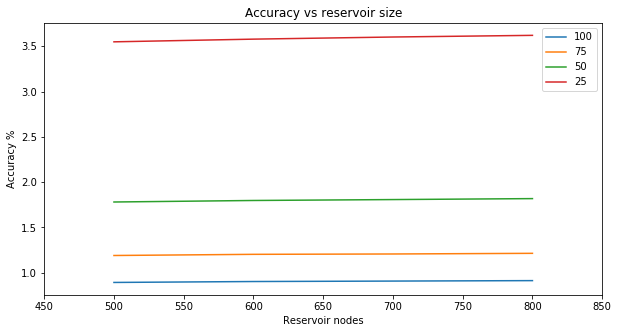

In [15]:
fig, ax = plt.subplots()
for size in [100, 75, 50, 25]:
	lists = sorted(results[size].items())
	x, y = zip(*lists)
	y = np.asarray(y)

	mean_accuracy = np.mean(y, axis=1)
	error_accuracy = np.std(y, axis=1)

	ax.plot(x, mean_accuracy, label=str(size))
	ax.set_title('Accuracy vs reservoir size')
	ax.set_xlabel('Reservoir nodes')
	ax.set_ylabel('Accuracy %')
	ax.set_xticks(range(450, 851, 50))
ax.legend()
fig.set_size_inches(10, 5)
fig.savefig('res_nodes_reduced.png')

In [ ]:
lists = sorted(stats.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

fig, ax = plt.subplots(10, 5)
fig.set_size_inches(15, 25)
fig.set_tight_layout({'pad': 1})

min_val = min(lists, key=itemgetter(1))[1]
max_val = max(lists, key=itemgetter(1))[1]

ax_i = 0
for res_size in SIZES:
	ax_j = 0
	for alpha in ALPHA:
		values = [(elem[0][2], elem[1]) for elem in lists
		          if elem[0][0] == res_size and elem[0][1] == alpha]

		ax[ax_i][ax_j].set_ylim(min_val-1, max_val+1)
		maximum = ''
		try:
			maximum = max(values, key=itemgetter(1))[1]
		except ValueError:
			pass
		ax[ax_i][ax_j].plot(*zip(*values), label=str(maximum))

		ax[ax_i][ax_j].set_title(f'{res_size} nodes, {alpha} leakage')
		ax[ax_i][ax_j].legend()
		ax_j += 1
	ax_i += 1

fig.savefig('res_650.png')

In [ ]:
with open('results_reduced.txt', 'w') as fp:
    fp.write('\n'.join('%s %s' % x for x in lists))

In [9]:
results_file = []
with open('results_reduced.txt', 'r') as fp:
    for line in fp:
	    results_file.append(eval(line))

results = {}

for result in results_file:
	for key, value in result.items():
		results[key] = value